# Проект по ПВМС с Python #

Целта на този проект е да видим как различните алгоритми за клъстеризация като Kmeans, Kprototypes, DBSCAN ще разделят данните в клъстери, да видим как се разделят данните и как ще изглеждат разделени, има ли сходства между клъстерите и различните здравословни показатели.

## Импортираме библиотеките и данните

In [101]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn

In [102]:
import warnings

In [103]:
## Преглеждане на текущата директория, за да достъпим във файла с данните
import os
current_directory = os.getcwd()
print(current_directory) 

C:\Users\lucho\Desktop


In [104]:
# Запазваме данните в собствен Dataframe variable HFRD и показваме колко реда и колони има
HFRD = pd.read_csv("heart_failure_clinical_records_dataset.xls")
print('Size of heart failure clinical dataframe is :', HFRD.shape)

Size of heart failure clinical dataframe is : (299, 13)


In [105]:
# Демонстрация на данните
HFRD.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [106]:
#Искаме да видим какъв е типът на нашите данни
HFRD.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

## Data Preprocessing

In [107]:
## избор на колини за клъстеризация (по тях ще съдим за състоянието на пациентите)
cluster_columns = ['age', 'sex', 'serum_creatinine', 'platelets', 'high_blood_pressure']
HFRD = HFRD[cluster_columns]

In [108]:
from sklearn.preprocessing import StandardScaler
# Дефиниране на числените и категорийните колони
# Ще ни трябва по-нататък, когато клъстеризираме с Kprototypes
numerical_cols = ['age', 'serum_creatinine', 'platelets']
categorical_cols = ['sex', 'high_blood_pressure']

Sscaler = StandardScaler()

In [109]:
HFRD_scale = HFRD.copy()

In [110]:
# Мащабираме данните със StandardScaler, за да може feature-ите ни да са със сходна размерност
for c in numerical_cols:
    HFRD_scale[c] = Sscaler.fit_transform(HFRD[[c]])
HFRD_scale.head()

,age,sex,serum_creatinine,platelets,high_blood_pressure
0,1.192945,1,0.490057,1.681648e-02,1
1,-0.491279,1,-0.284552,7.535660e-09,0
2,0.350833,1,-0.090900,-1.038073e+00,0
3,-0.912335,1,0.490057,-5.464741e-01,0
4,0.350833,0,1.264666,6.517986e-01,0


In [111]:
#Премахване на  outlier-ите за всяка от избраните ни колони
HFRD_out = HFRD_scale[(HFRD_scale['age'].abs()<=3) & (HFRD_scale['platelets'].abs()<=3) & (HFRD_scale['serum_creatinine'].abs()<=3)& (HFRD_scale['sex'].abs()<=3)& (HFRD_scale['high_blood_pressure'].abs()<=3)]
HFRD_out.shape

(290, 5)

In [112]:
## Намиране на оптимален брой клъстери чрез Elbow Method и Average Silhouette Method за Kmeans и КPrototypes
## импортиране на допълнителни библиотеки за методите ,които ще ползваме
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans


In [113]:
cat_index = []
for i in categorical_cols:
    cat_index.append(HFRD.columns.get_loc(i))
    
cat_index

[1, 4]

In [114]:
number_of_clusters = list(range(2, 11))
## изчисляваме цена(cost) за всеки брой от клъстери(от 2 до 10)
cost_values = []
for k in number_of_clusters:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit_predict(HFRD_scale)
    cost_values.append(kmeans.inertia_)

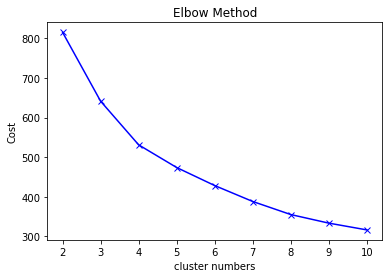

In [115]:
## Графично изобразяваме цена(cost) срещу брой клъстери
plt.plot(number_of_clusters,cost_values,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.ylabel('Cost')
plt.show()

In [116]:
## От горната графика виждаме,че оптималният брой на клъстерите би бил някъде между 3 и 4
## (там кривата започва да се чупи, т.е да получаваме лакът(Elbow))

##За това ще ползваме и аverage silhouette method 
from sklearn.metrics import silhouette_score

In [117]:
silhouette_average = []

In [118]:
## изчисляваме score за всеки брой от клъстери(от 2 до 10) за Kmeans
for k in number_of_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_predict(HFRD_scale)
    Cluster_labels = kmeans.labels_
    silhouette_average.append(silhouette_score(HFRD_scale, Cluster_labels))

Text(0, 0.5, 'score')

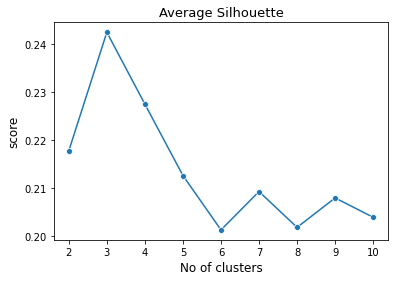

In [119]:
## Графично изобразяваме average silhouette score срещу брой клъстери
ax = sns.lineplot(x=number_of_clusters, y=silhouette_average, marker="o")
ax.set_title('Average Silhouette', fontsize=13)
ax.set_xlabel('No of clusters', fontsize=12)
ax.set_ylabel('score', fontsize=12)

In [ ]:
## На горната графика виждаме по-добре, че при избор на брой клъстери равен на 3 ще получим най-добър резултат за наштие данни
## Оценката(score) е доста ниска (0.24), което предполага, че нашите клъстери са доста идентични 

## Clustering with Кmeans

In [120]:
## За Kmeans ще ползваме 3 клъстера
kmeans = KMeans(n_clusters= 3)
kmeans.fit_predict(HFRD_scale)

## Запазваме си етикетите за клъстерите
Cluster_labels = kmeans.labels_

In [121]:
## Добавяме клъстерите към dataframe-а
HFRD["cluster"] = Cluster_labels

In [122]:
HFRD.head()

,age,sex,serum_creatinine,platelets,high_blood_pressure,cluster
0,75.0,1,1.9,265000.00,1,2
1,55.0,1,1.1,263358.03,0,1
2,65.0,1,1.3,162000.00,0,2
3,50.0,1,1.9,210000.00,0,1
4,65.0,0,2.7,327000.00,0,2


In [123]:
## Визуализация на данните
from sklearn.decomposition import PCA

In [124]:
## Ползваме PCA, за да намалил размерността от 5 колони на 3 и plotly за 3D визуализация
pcaM = PCA(n_components=3)
pcaM_HFRD = pcaM.fit_transform(HFRD_scale)

In [125]:
import plotly.graph_objects as go


fig = go.Figure(
    go.Scatter3d(mode='markers',
                 x = pcaM_HFRD[:, 0],
                 y = pcaM_HFRD[:, 1],
                 z = pcaM_HFRD[:, 2],
                 marker=dict(size = 5, color = HFRD['cluster'], colorscale = 'viridis')
                )
)
    
fig.show()

In [126]:
## На горната графика можем да видим как изглеждат нашите 3 клъстера (2 сравнително близки и един, койти взима по-отдалечени точки)
## Това ни показва, че пациентите имат сходни здравословни показатели, но очевидно нещо друго ги разделя в различните клъстери 
## Тук наблюдаваме по колко човека(точки) имаме във всеки клъстер
HFRD["cluster"].value_counts()

2    155
1    131
0     13
Name: cluster, dtype: int64

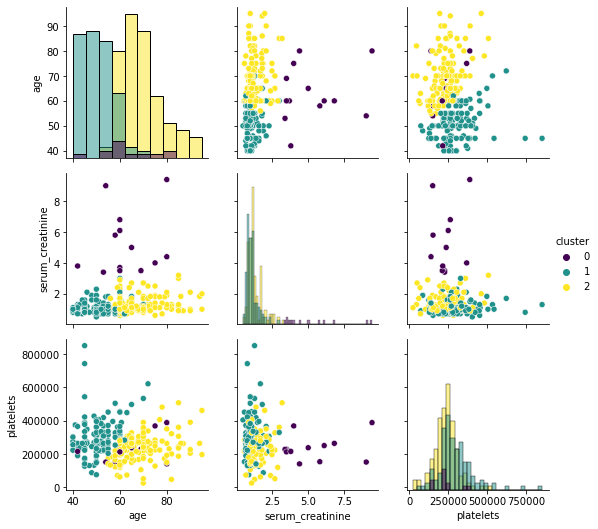

In [127]:
g = sns.PairGrid(HFRD[["age", "serum_creatinine", "platelets", "cluster"]], hue = "cluster", palette = 'viridis')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

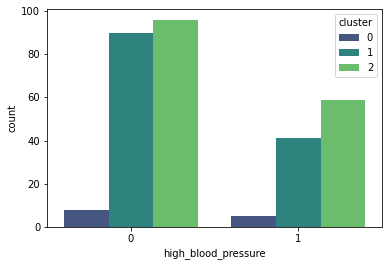

In [128]:
## На горната графики виждаме някои от показателите за пациентите и можем да кажем ,че за най-малкият клъстер(тъмния цвят),
## се състои предимно от по-млади хора с високи нива на креатинин и ниски нива на plateletes, което е по-характерно за тази възраст

## За останалите 2 клъстера наблюдаваме обратните тенденции, имайки предвид, че те се състоят от по-възрастни индивиди 
ax = sns.countplot(data = HFRD, x="high_blood_pressure", hue = "cluster", palette = 'viridis' )

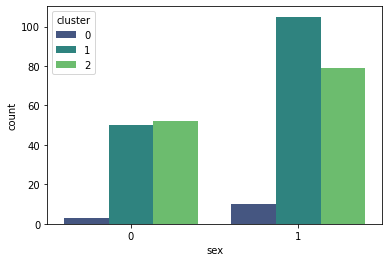

In [78]:
## На тази графика виждаме разпределението в отделните клъстери на базата на високо кръвно налягане
## Mожем да направим връзка между напредналата възраст и наличието на високо кръвно налягане между отделните клъстери

ax = sns.countplot(data = HFRD, x="sex", hue = "cluster", palette = 'viridis' )

In [79]:
## На тази графика виждаме разпределението в отделните клъстери на базата на пола на пациента


HFRD[HFRD["cluster"] == 2].describe()

,age,sex,serum_creatinine,platelets,high_blood_pressure,cluster
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.0
mean,50.882954,0.603053,1.102595,298472.811679,0.312977,2.0
std,6.401115,0.491143,0.394806,111013.735871,0.465485,0.0
min,40.000000,0.000000,0.500000,75000.000000,0.000000,2.0
25%,45.000000,0.000000,0.800000,234000.000000,0.000000,2.0
50%,50.000000,1.000000,1.000000,275000.000000,0.000000,2.0
75%,55.000000,1.000000,1.200000,336500.000000,1.000000,2.0
max,72.000000,1.000000,3.000000,850000.000000,1.000000,2.0


Text(0, 0.5, 'Cost')

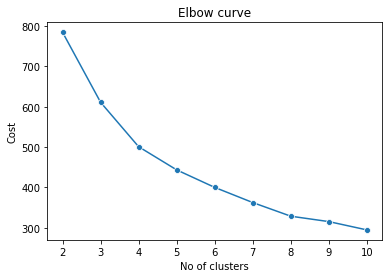

In [80]:
## Ще направим отнво същото само че за Kprototypes 
number_of_clusters = list(range(2, 11))

Cost_values = []

## изчисляваме цена(cost) за всеки брой от клъстери(от 2 до 10)
for k in number_of_clusters:
    kproto = KPrototypes(n_clusters = k, init='Huang', random_state=42)
    kproto.fit_predict(HFRD_scale, categorical= cat_index)
    Cost_values.append(kproto.cost_)

## Графично изобразяваме цена(cost) срещу брой клъстери
ax = sns.lineplot(x=number_of_clusters, y=Cost_values, marker="o")
ax.set_title('Elbow curve', fontsize=12)
ax.set_xlabel('No of clusters', fontsize=10)
ax.set_ylabel('Cost', fontsize=10)

Text(0, 0.5, 'score')

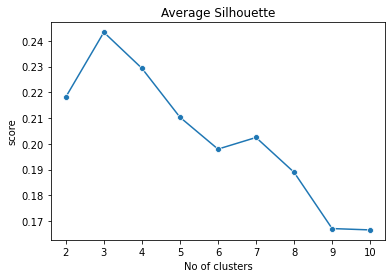

In [81]:
## От горната графика се вижда,че оптималният брой на клъстерите би бил някъде между 3 и 4 отново
silhouette_average = []
## изчисляваме score за всеки брой от клъстери(от 2 до 10) за Kprototypes
for k in number_of_clusters:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
    kproto.fit_predict(HFRD_scale, categorical= cat_index)
    Cluster_labels = kproto.labels_
    silhouette_average.append(silhouette_score(HFRD_scale, Cluster_labels))

## Графично изобразяваме average silhouette score срещу брой клъстери
ax = sns.lineplot(x=number_of_clusters, y=silhouette_average, marker="o")
ax.set_title('Average Silhouette', fontsize=12)
ax.set_xlabel('No of clusters', fontsize=10)
ax.set_ylabel('score', fontsize=10)

In [ ]:
## Отново се получава ,че идеалният за нас брой клъстери е 3
##(това не е неочаквано съвпадение имайки предвид сходността между Kmeans и Kprototypes)

## Clustering with KPrototypes

In [82]:
## За KPrototypes ще ползваме 3 клъстера
kproto = KPrototypes(n_clusters= 3, init='Huang', n_init = 25, random_state=42)
kproto.fit_predict(HFRD_scale, categorical= cat_index)

## Запазваме етикетите за клъстерите
Cluster_labels = kproto.labels_

## Добавяме клъстерите към dataframe-а
HFRD["cluster"] = Cluster_labels
HFRD.head()

,age,sex,serum_creatinine,platelets,high_blood_pressure,cluster
0,75.0,1,1.9,265000.00,1,1
1,55.0,1,1.1,263358.03,0,0
2,65.0,1,1.3,162000.00,0,1
3,50.0,1,1.9,210000.00,0,0
4,65.0,0,2.7,327000.00,0,1


In [83]:
## Визуализация на данните(отново с PCA)
pcaProto = PCA(n_components=3)
pcaProto_HFRD = pcaProto.fit_transform(HFRD_scale)

import plotly.graph_objects as go


fig = go.Figure(
    go.Scatter3d(mode='markers',
                 x = pcaProto_HFRD[:, 0],
                 y = pcaProto_HFRD[:, 1],
                 z = pcaProto_HFRD[:, 2],
                 marker=dict(size = 5, color = HFRD['cluster'], colorscale = 'viridis')
                )
)
    
fig.show()
## Тук виждаме по-колко човека(точки имаме във всеки клъстер)
HFRD["cluster"].value_counts()

1    157
0    129
2     13
Name: cluster, dtype: int64

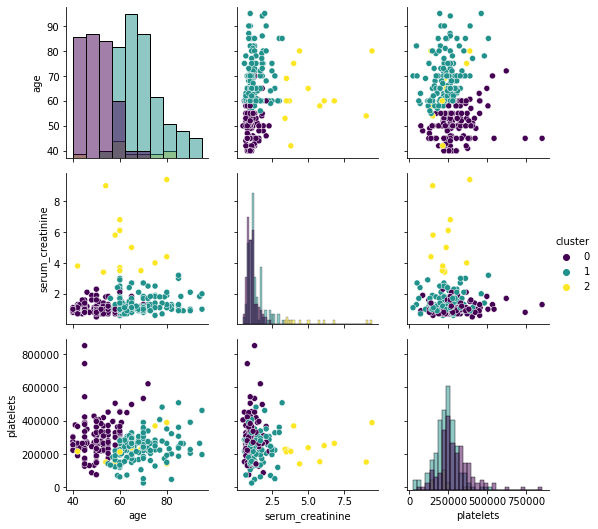

In [84]:
## На графиката отгоре виждаме много сходно(почти еднакво) разделение на 3-те клъстера,
## но когато погледнем броят на пацеунтите(точките) във всеки клъстер виждаме,че има малко разлика в броя

g = sns.PairGrid(HFRD[["age", "serum_creatinine", "platelets", "cluster"]], hue = "cluster", palette = 'viridis')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

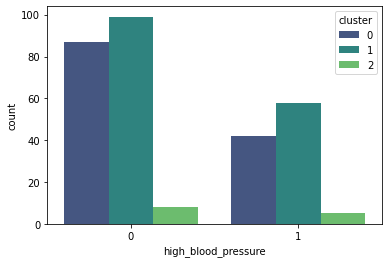

In [85]:
## Тъй като алгоритмите са сходни можем да наблюдаваме сходни резултати за горните графики 
## по отношение на здравословните показатели на пациентите


ax = sns.countplot(data = HFRD, x="high_blood_pressure", hue = "cluster", palette = 'viridis' )

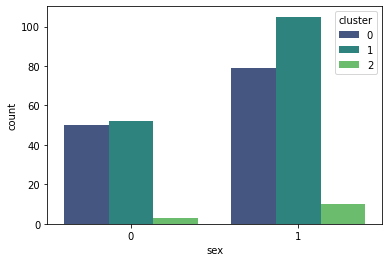

In [86]:
## На тази графика виждаме разпределението в отделните клъстери на базата на високо кръвно налягане
ax = sns.countplot(data = HFRD, x="sex", hue = "cluster", palette = 'viridis' )

In [ ]:
## На тази графика виждаме разпределението в отделните клъстери на базата на пола на пациента
HFRD[HFRD["cluster"] == 2].describe()

## Извод от клъстеризация с Kmeans и Kprototypes:

## Двата алгоритъма са сходни като реализация и резултат
## Kprototypes се справя по-добре от Kmeans с категориинте данни

## Ще направим същото и с DBSCAN

In [88]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()

In [89]:
DBclusters = dbscan.fit_predict(HFRD_scale)

In [90]:
DBclusters_labels = dbscan.labels_

In [91]:
HFRD["cluster"] = DBclusters_labels

In [92]:
HFRD.head()

,age,sex,serum_creatinine,platelets,high_blood_pressure,cluster
0,75.0,1,1.9,265000.00,1,-1
1,55.0,1,1.1,263358.03,0,0
2,65.0,1,1.3,162000.00,0,1
3,50.0,1,1.9,210000.00,0,-1
4,65.0,0,2.7,327000.00,0,-1


In [93]:
##Визуализация с PCA

pcaDB = PCA(n_components=3)
pcaDB_HFRD = pcaDB.fit_transform(HFRD_scale)
fig = go.Figure(
    go.Scatter3d(mode='markers',
                 x = pcaDB_HFRD[:, 0],
                 y = pcaDB_HFRD[:, 1],
                 z = pcaDB_HFRD[:, 2],
                 marker=dict(size = 5, color = HFRD['cluster'], colorscale = 'viridis')
                )
)
    
fig.show()
HFRD["cluster"].value_counts()

-1    130
 0     71
 3     35
 2     26
 1     13
 4      8
 7      6
 5      5
 6      5
Name: cluster, dtype: int64

## На горната графика виждаме,че имаме 9 различни клъстера
## Тъй като броят на клъстерите е твърде голям , не можем да направим добра обосновка за получените графики и 
## получените клъстери са твърде различни по между си

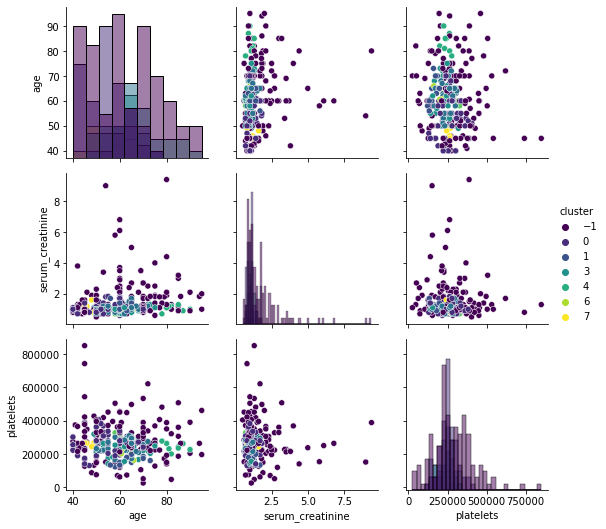

In [94]:
g = sns.PairGrid(HFRD[["age", "serum_creatinine", "platelets", "cluster"]], hue = "cluster", palette = 'viridis')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

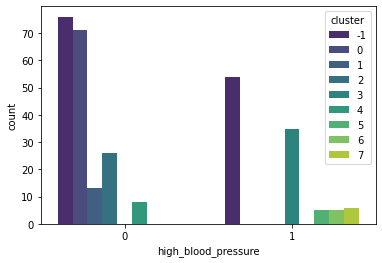

In [95]:
ax = sns.countplot(data = HFRD, x="high_blood_pressure", hue = "cluster", palette = 'viridis' )

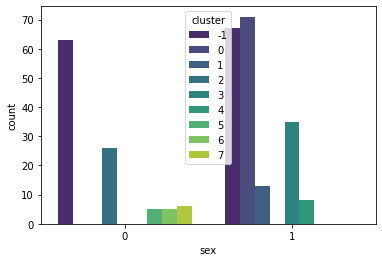

In [96]:
ax = sns.countplot(data = HFRD, x="sex", hue = "cluster", palette = 'viridis' )

In [97]:
HFRD[HFRD["cluster"] == 2].describe()

,age,sex,serum_creatinine,platelets,high_blood_pressure,cluster
count,26.000000,26.0,26.000000,26.000000,26.0,26.0
mean,62.038462,0.0,1.055769,244412.156154,0.0,2.0
std,5.813644,0.0,0.247518,37540.937634,0.0,0.0
min,50.000000,0.0,0.700000,164000.000000,0.0,2.0
25%,58.500000,0.0,0.900000,221000.000000,0.0,2.0
50%,63.500000,0.0,1.000000,249500.000000,0.0,2.0
75%,65.000000,0.0,1.200000,270000.000000,0.0,2.0
max,72.000000,0.0,1.700000,309000.000000,0.0,2.0
